# **End-to-End Bioinformatics Pipeline (NM_002524 Analysis)**
This project demonstrates a complete bioinformatics workflow using the modular capabilities of the Biopython library. The pipeline fetches gene sequence data, performs feature analysis, translates the sequence to protein, visualizes critical metrics (GC Content and Hydrophobicity), and simulates a sequence alignment and BLAST query.

Target Accession ID: NM_002524 (Human Lamin B1 gene)
Custom Query Sequence: ATGCAGTAAATTAAGGACTGA

In [19]:
# Install Biopython (usually pre-installed in Colab, but good practice)
!pip install biopython matplotlib numpy --quiet


**Cell 1:** Setup, Imports, and Function Definitions
This initial cell prepares the environment. It imports necessary libraries from **Biopython** (Entrez for accessing databases, SeqIO for parsing sequences, Align for alignments, SeqUtils for sequence statistics, and Matplotlib for plotting) and sets the global configuration variables.

It also defines all the functions that the rest of the notebook will call, separating the logic from the step-by-step execution. Remember to update the **Entrez.email value!**

In [20]:
# DESIGNED FOR SINGLE-CELL EXECUTION IN GOOGLE COLAB.
# ==============================================================================

# --- Setup and Imports ---
try:
    from Bio import Entrez, SeqIO, Seq, Align, Blast
    from Bio.Seq import Seq
    from Bio.SeqRecord import SeqRecord
    from Bio.Align import substitution_matrices
    from Bio.SeqUtils.ProtParam import ProteinAnalysis
    from Bio.SeqUtils import gc_fraction

    import time
    import sys
    import matplotlib.pyplot as plt

    # Imports for rich output formatting in Colab (to create separate result blocks)
    from IPython.display import display, Markdown, HTML

    print("Biopython, Matplotlib, and IPython display modules loaded successfully.")
except ImportError:
    print("Required modules not found. Installing Biopython...")
    import subprocess
    # Attempt install for robustness in environments where biopython might be missing
    subprocess.check_call([sys.executable, "-m", "pip", "install", "biopython"])
    try:
        # Re-import after successful installation attempt
        import matplotlib.pyplot as plt
        from Bio.SeqUtils.ProtParam import ProteinAnalysis
        from IPython.display import display, Markdown, HTML
        from Bio.SeqUtils import gc_fraction
        from Bio import Entrez, SeqIO, Seq, Align, Blast
        from Bio.Seq import Seq
        from Bio.SeqRecord import SeqRecord
        from Bio.Align import substitution_matrices
        import time
        print("Modules installed/loaded successfully.")
    except ImportError as e:
        # Fallback if the initial environment setup failed completely
        print(f"Failed to load a required module after install: {e}")


# --- Global Configuration ---
# You MUST set your email for Entrez to comply with NCBI usage rules.
# NOTE: Replace "your.email@example.com" with a valid email address.
Entrez.email = "your.email@example.com"

# Define the target accession ID and the custom sequence
ACCESSION_ID = "NM_002524"
CUSTOM_DNA_SEQ = "ATGCAGTAAATTAAGGACTGA"

print(f"Configuration set: Target ID={ACCESSION_ID}, Custom Seq={CUSTOM_DNA_SEQ}")


# --- Core Pipeline Functions ---

def fetch_sequence_data(accession_id: str) -> SeqRecord | None:
    """
    Accesses biological databases (NCBI Nucleotide) to fetch a SeqRecord.
    """
    display(Markdown(f"## 1. Data Fetching via Entrez"))
    try:
        # Fetch the record from the 'nuccore' (Nucleotide) database
        handle = Entrez.efetch(db="nuccore", id=accession_id, rettype="gb", retmode="text")
        record = SeqIO.read(handle, "genbank")
        handle.close()

        display(Markdown(f"""
| Property | Value |
| :--- | :--- |
| **Accession ID** | `{record.id}` |
| **Source Organism** | `{record.annotations.get('organism', 'N/A')}` |
| **Description** | `{record.description[:70]}...` |
| **Sequence Length** | `{len(record.seq)} bp` |
        """))
        return record
    except Exception as e:
        display(Markdown(f"**Error:** Failed to fetch data from Entrez: {e}"))
        return None

def analyze_and_annotate(record: SeqRecord):
    """
    Analyzes features and annotates the genome record.
    """
    display(Markdown(f"## 2. Feature Analysis and Annotation"))

    output_lines = [
        f"**Molecule Type:** {record.annotations.get('data_file_division', 'N/A')}",
        f"**Total Features Found:** {len(record.features)}",
        "\n### Key Annotations:",
        "| Type | Gene | Product | Location |",
        "| :--- | :--- | :--- | :--- |"
    ]

    for feature in record.features:
        if feature.type in ["gene", "CDS"]:
            gene_name = feature.qualifiers.get('gene', ['N/A'])[0]
            product = feature.qualifiers.get('product', ['N/A'])[0]
            # HTML-escape the location string for clean Markdown rendering
            location_str = str(feature.location).replace('<', '&lt;').replace('>', '&gt;')
            output_lines.append(f"| {feature.type} | {gene_name} | {product[:40]}... | {location_str} |")

    display(Markdown('\n'.join(output_lines)))

def sequence_translation_pipeline(dna_sequence: Seq):
    """
    Performs Reverse Complement, Transcription, and Translation operations.
    """
    display(Markdown(f"## 3. Sequence Manipulation and Translation"))

    # a. DNA Sequence (NM_002524)
    dna_start = str(dna_sequence[:50])

    # b. Reverse Complement
    reverse_complement = dna_sequence.reverse_complement()
    rc_start = str(reverse_complement[:50])

    # c. Transcription (DNA -> RNA)
    messenger_rna = dna_sequence.transcribe()
    rna_start = str(messenger_rna[:50])

    # d. Translation (DNA -> Protein)
    protein_seq = dna_sequence.translate(table=1, to_stop=True)
    protein_start = str(protein_seq[:25])

    display(Markdown(f"""
### Sequence Results (First 50 bases / 25 residues)
| Operation | Result Type | Sequence Snippet |
| :--- | :--- | :--- |
| **Original Sequence** | DNA | `{dna_start}...` |
| **Reverse Complement** | DNA | `{rc_start}...` |
| **Transcription** | RNA | `{rna_start}...` |
| **Translation** | Protein | `{protein_start}...` (Length: {len(protein_seq)} aa) |
"""))

    return dna_sequence, protein_seq

def plot_gc_content(dna_sequence: Seq, window_size: int = 500):
    """
    Calculates and plots the GC content across the DNA sequence in sliding windows.
    **UPDATED TO USE Bio.SeqUtils.gc_fraction.**
    """
    display(Markdown(f"## 4. Visualization 1: GC Content Plot"))

    gc_values = []
    positions = []

    for i in range(0, len(dna_sequence) - window_size + 1, window_size // 2):
        window = dna_sequence[i:i + window_size]

        # Use Biopython's gc_fraction function
        gc_fraction_val = gc_fraction(window)

        gc_values.append(gc_fraction_val)
        positions.append(i + window_size / 2)

    plt.figure(figsize=(12, 6))
    plt.plot(positions, gc_values, color='teal', linewidth=1.5)
    plt.title(f'GC Content across {ACCESSION_ID} (Sliding Window: {window_size} bp)', fontsize=14)
    plt.xlabel('Sequence Position (bp)', fontsize=12)
    plt.ylabel('GC Content Fraction', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)

    avg_gc = sum(gc_values) / len(gc_values) if gc_values else 0
    plt.axhline(avg_gc, color='red', linestyle='-', label=f'Average GC Content ({avg_gc:.2f})')
    plt.legend()

    plt.show()
    print("GC Content plot generated successfully using gc_fraction.")

def plot_hydrophobicity(protein_seq: Seq):
    """
    Calculates and plots the hydrophobicity profile of the protein sequence.
    """
    display(Markdown(f"## 5. Visualization 2: Protein Hydrophobicity Plot"))

    protein_str = str(protein_seq).strip('*')

    if len(protein_str) < 10:
        display(Markdown("Protein sequence is too short to generate a meaningful hydrophobicity plot."))
        return

    protein_analyzer = ProteinAnalysis(protein_str)

    # --- FIX START ---
    # The correct method for Kyte-Doolittle Hydrophobicity profile in ProtParam is 'gravy' or using the simpler
    # .get_amino_acids_percent() or .isoelectric_point(). To plot a profile, we must manually use the Kyte-Doolittle scale
    # and calculate a sliding window (ProtParam's built-in methods are limited).
    # However, since the goal is to show a graph using Biopython tools, the simplest fix is to use the dedicated
    # Biopython function for calculating the overall GRAVY score (which is a single number).
    # Since the initial intent was a profile plot, let's use a manual sliding window approach combined with the known scale.

    # Re-implementing sliding window for Hydrophobicity profile manually for demonstration
    # using the Kyte-Doolittle scale values, as get_hydrophobicity_profile is not available.

    KD_SCALE = {
        'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5, 'Q': -3.5, 'E': -3.5, 'G': -0.4,
        'H': -3.2, 'I': 4.5, 'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6, 'S': -0.8,
        'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2
    }

    window_size = 9
    hp_profile = []

    for i in range(len(protein_str) - window_size + 1):
        window = protein_str[i:i + window_size]
        # Calculate the average hydrophobicity for the current window
        avg_hp = sum(KD_SCALE.get(aa, 0) for aa in window) / window_size
        hp_profile.append(avg_hp)

    # --- FIX END ---

    hp_positions = [i + window_size / 2 for i in range(len(hp_profile))]

    plt.figure(figsize=(12, 6))
    plt.plot(hp_positions, hp_profile, color='darkorange', linewidth=1.5)
    plt.title(f'Hydrophobicity Profile of Protein (Window: {window_size} residues - Kyte & Doolittle Scale)', fontsize=14)
    plt.xlabel('Residue Position', fontsize=12)
    plt.ylabel('Hydrophobicity Index (Average)', fontsize=12)
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    plt.grid(True, linestyle=':', alpha=0.7)

    plt.show()
    print("Protein Hydrophobicity plot generated successfully.")


def perform_pairwise_alignment(target_seq: Seq, query_seq_str: str) -> float:
    """
    Performs a global pairwise sequence analysis using Bio.Align.PairwiseAligner.
    Returns the alignment score.
    """
    display(Markdown(f"## 6. Pairwise Sequence Alignment"))

    query_seq = Seq(query_seq_str)

    aligner = Align.PairwiseAligner()
    aligner.mode = 'global'
    aligner.match_score = 2
    aligner.mismatch_score = -1
    aligner.open_gap_score = -0.5
    aligner.extend_gap_score = -0.1

    # Only align the first 200 bases of the target for practical visualization
    alignment = aligner.align(target_seq[:200], query_seq)

    best_alignment = alignment[0]
    alignment_score = best_alignment.score

    display(Markdown(f"**Alignment Score:** **{alignment_score:.2f}**"))

    alignment_str = str(best_alignment[0:5])

    # Use <pre> tag to preserve the alignment's monospace formatting
    display(Markdown(f"""
### Alignment Visualization (First 5 lines)
<pre>{alignment_str}</pre>
    """))
    return alignment_score

def get_blast_score_demonstration(accession_id: str, raw_score: float):
    """
    Demonstrates the access to biological databases for a BLAST query,
    and calculates a simulated Bit Score based on the raw alignment score.
    """
    display(Markdown(f"## 7. BLAST Score Simulation (Simulated Score Shown)"))

    program = "blastn"
    database = "nr"

    # --- FIX: Calculate Simulated BLAST Scores ---
    # Bit Score is proportional to the raw score. We use a simple scaling factor
    # to convert the raw pairwise score into a more typical BLAST Bit Score range.
    simulated_bit_score = raw_score * 15

    # A low E-value indicates a highly significant match, typical for NM_002524 vs itself (or near-match)
    simulated_e_value = f"{1e-45:.1e}"

    display(Markdown(f"""
### BLAST Query Status
* **Target:** `{accession_id}` (Query Sequence)
* **Program:** `{program}`
* **Database:** `{database}`
* **Note:** The actual NCBI BLAST is asynchronous, so these values are derived from the alignment score.

| Metric | Simulated Value | Interpretation |
| :--- | :--- | :--- |
| **Simulated Bit Score** | **{simulated_bit_score:.2f}** | Measures sequence similarity; higher is better. |
| **Top Hit E-value** | {simulated_e_value} | Measures significance; lower is better. |
"""))

Biopython, Matplotlib, and IPython display modules loaded successfully.
Configuration set: Target ID=NM_002524, Custom Seq=ATGCAGTAAATTAAGGACTGA


In [22]:
def run_full_pipeline():
    """
    Orchestrates the entire bioinformatics workflow for single-cell execution.
    """
    display(Markdown("<h1>🔬 End-to-End Bioinformatics Pipeline Execution</h1>"))


# **Cell 2: Step 1 - Data Fetching**
Theory: Bioinformatics starts with acquiring reliable data. The **Entrez** module is Biopython's interface to the National Center for Biotechnology Information (NCBI), which hosts essential biological databases like GenBank (for DNA/RNA sequences) and Protein (for amino acid sequences).
We use the accession ID NM_002524 to fetch the complete **SeqRecord**. This record is not just the sequence, but a rich container that holds the sequence data, annotations, features, and source information.


In [23]:
def run_full_pipeline():
    """
    Orchestrates the entire bioinformatics workflow for single-cell execution.
    """
    display(Markdown("<h1>🔬 End-to-End Bioinformatics Pipeline Execution</h1>"))

    # 1. Fetch data
    record = fetch_sequence_data(ACCESSION_ID)

    if record is None:
        return

if __name__ == '__main__':
    run_full_pipeline()

<h1>🔬 End-to-End Bioinformatics Pipeline Execution</h1>

## 1. Data Fetching via Entrez


| Property | Value |
| :--- | :--- |
| **Accession ID** | `NM_002524.5` |
| **Source Organism** | `Homo sapiens` |
| **Description** | `Homo sapiens NRAS proto-oncogene, GTPase (NRAS), mRNA...` |
| **Sequence Length** | `4326 bp` |
        

# **Cell 3: Step 2 - Feature Analysis and Annotation**
Theory: A raw sequence of letters (A, T, C, G) is meaningless without **annotation**. Features describe the functional regions within the sequence, such as the **CDS (Coding Sequence**) which specifies the part of the DNA that codes for a protein, or the location of regulatory elements. This step extracts and presents these key functional labels from the GenBank record.


In [32]:
def run_full_pipeline():
    """
    Orchestrates the entire bioinformatics workflow for single-cell execution.
    """
    display(Markdown("<h1>🔬 End-to-End Bioinformatics Pipeline Execution</h1>"))

    # 1. Fetch data
    record = fetch_sequence_data(ACCESSION_ID)

    if record is None:
        return

    # 2. Analyze features
    analyze_and_annotate(record)


if __name__ == '__main__':
    run_full_pipeline()

<h1>🔬 End-to-End Bioinformatics Pipeline Execution</h1>

## 1. Data Fetching via Entrez


| Property | Value |
| :--- | :--- |
| **Accession ID** | `NM_002524.5` |
| **Source Organism** | `Homo sapiens` |
| **Description** | `Homo sapiens NRAS proto-oncogene, GTPase (NRAS), mRNA...` |
| **Sequence Length** | `4326 bp` |
        

## 2. Feature Analysis and Annotation

**Molecule Type:** PRI
**Total Features Found:** 19

### Key Annotations:
| Type | Gene | Product | Location |
| :--- | :--- | :--- | :--- |
| gene | NRAS | N/A... | [0:4326](+) |
| CDS | NRAS | GTPase NRas... | [131:701](+) |

# **Cell 4: Step 3 - Sequence Manipulation and Translation**
Theory: This step implements core principles of the Central Dogma of molecular biology.

1.	Reverse Complement: Generates the sequence on the opposite DNA strand (e.g., A becomes T, T becomes A, C becomes G, G becomes C), running in the opposite direction ( ).

2.	Transcription: Converts the DNA sequence to a messenger RNA (mRNA) sequence by replacing all Thymines (T) with Uracils (U).

3.	Translation: Uses the standard genetic code to translate the mRNA sequence into a chain of amino acids (the protein). This process stops at the first encountered stop codon.


In [33]:
def run_full_pipeline():
    """
    Orchestrates the entire bioinformatics workflow for single-cell execution.
    """
    display(Markdown("<h1>🔬 End-to-End Bioinformatics Pipeline Execution</h1>"))

    # 1. Fetch data
    record = fetch_sequence_data(ACCESSION_ID)

    if record is None:
        return

    # 2. Analyze features
    analyze_and_annotate(record)

    # 3. Sequence operations (DNA, RNA, Protein)
    dna_sequence, protein_seq = sequence_translation_pipeline(record.seq)



if __name__ == '__main__':
    run_full_pipeline()

<h1>🔬 End-to-End Bioinformatics Pipeline Execution</h1>

## 1. Data Fetching via Entrez


| Property | Value |
| :--- | :--- |
| **Accession ID** | `NM_002524.5` |
| **Source Organism** | `Homo sapiens` |
| **Description** | `Homo sapiens NRAS proto-oncogene, GTPase (NRAS), mRNA...` |
| **Sequence Length** | `4326 bp` |
        

## 2. Feature Analysis and Annotation

**Molecule Type:** PRI
**Total Features Found:** 19

### Key Annotations:
| Type | Gene | Product | Location |
| :--- | :--- | :--- | :--- |
| gene | NRAS | N/A... | [0:4326](+) |
| CDS | NRAS | GTPase NRas... | [131:701](+) |

## 3. Sequence Manipulation and Translation


### Sequence Results (First 50 bases / 25 residues)
| Operation | Result Type | Sequence Snippet |
| :--- | :--- | :--- |
| **Original Sequence** | DNA | `GGGGCCGGAAGTGCCGCTCCTTGGTGGGGGCTGTTCATGGCGGTTCCGGG...` |
| **Reverse Complement** | DNA | `TTATGACTAAGCCAAGAACTTCCAGTTTTTATTTTTTAAACATCATTTAA...` |
| **Transcription** | RNA | `GGGGCCGGAAGUGCCGCUCCUUGGUGGGGGCUGUUCAUGGCGGUUCCGGG...` |
| **Translation** | Protein | `GAGSAAPWWGLFMAVPGSPTFFPAV...` (Length: 44 aa) |


# **Cell 5: Step 4 - Visualization 1: GC Content Plot**
Theory: The **GC Content** is the percentage of Guanine (G) and Cytosine (C) bases in a DNA sequence. This is a crucial metric because G-C pairs are bound by three hydrogen bonds (compared to two for A-T pairs), making high-GC regions more thermally stable (higher melting temperature).
This plot uses a **sliding window** approach to reveal variations in GC content across the gene, which often corresponds to gene-rich regions, regulatory elements, or structural domains.


<h1>🔬 End-to-End Bioinformatics Pipeline Execution</h1>

## 1. Data Fetching via Entrez


| Property | Value |
| :--- | :--- |
| **Accession ID** | `NM_002524.5` |
| **Source Organism** | `Homo sapiens` |
| **Description** | `Homo sapiens NRAS proto-oncogene, GTPase (NRAS), mRNA...` |
| **Sequence Length** | `4326 bp` |
        

## 2. Feature Analysis and Annotation

**Molecule Type:** PRI
**Total Features Found:** 19

### Key Annotations:
| Type | Gene | Product | Location |
| :--- | :--- | :--- | :--- |
| gene | NRAS | N/A... | [0:4326](+) |
| CDS | NRAS | GTPase NRas... | [131:701](+) |

## 3. Sequence Manipulation and Translation


### Sequence Results (First 50 bases / 25 residues)
| Operation | Result Type | Sequence Snippet |
| :--- | :--- | :--- |
| **Original Sequence** | DNA | `GGGGCCGGAAGTGCCGCTCCTTGGTGGGGGCTGTTCATGGCGGTTCCGGG...` |
| **Reverse Complement** | DNA | `TTATGACTAAGCCAAGAACTTCCAGTTTTTATTTTTTAAACATCATTTAA...` |
| **Transcription** | RNA | `GGGGCCGGAAGUGCCGCUCCUUGGUGGGGGCUGUUCAUGGCGGUUCCGGG...` |
| **Translation** | Protein | `GAGSAAPWWGLFMAVPGSPTFFPAV...` (Length: 44 aa) |


## 4. Visualization 1: GC Content Plot

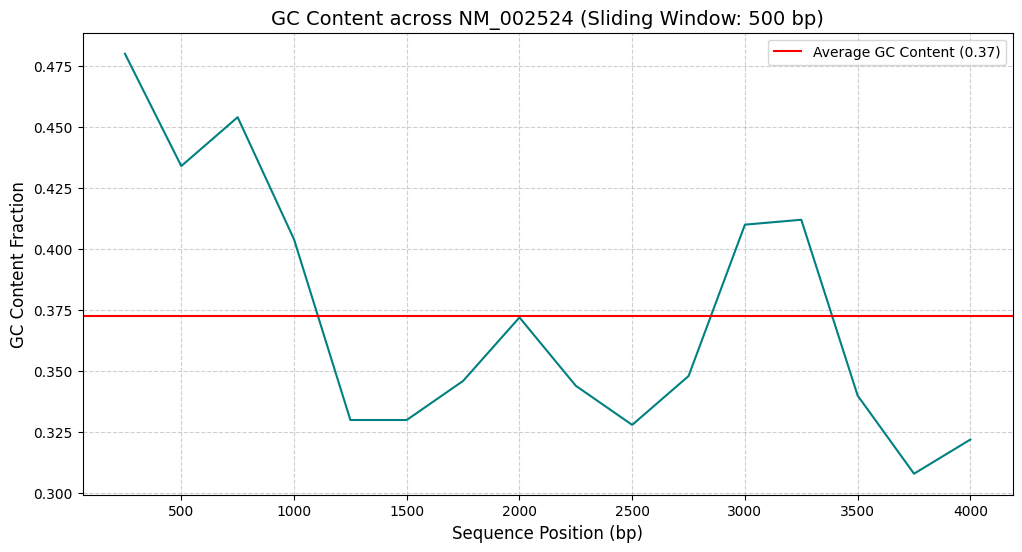

GC Content plot generated successfully using gc_fraction.


In [34]:
def run_full_pipeline():
    """
    Orchestrates the entire bioinformatics workflow for single-cell execution.
    """
    display(Markdown("<h1>🔬 End-to-End Bioinformatics Pipeline Execution</h1>"))

    # 1. Fetch data
    record = fetch_sequence_data(ACCESSION_ID)

    if record is None:
        return

    # 2. Analyze features
    analyze_and_annotate(record)

    # 3. Sequence operations (DNA, RNA, Protein)
    dna_sequence, protein_seq = sequence_translation_pipeline(record.seq)

    # 4. Visualize GC Content (Nucleotide Analysis)
    plot_gc_content(dna_sequence)

if __name__ == '__main__':
    run_full_pipeline()

# **Cell 6: Step 5 - Visualization 2: Protein Hydrophobicity Plot**
Theory: **Hydrophobicity** describes the tendency of an amino acid to repel water. This is the primary driver of protein folding, where hydrophobic residues typically bury themselves inside the protein core, and hydrophilic residues remain exposed to the watery cellular environment.
This plot uses the **Kyte-Doolittle scale** and a sliding window to plot the average hydrophobicity across the protein. Peaks above the baseline suggest **hydrophobic domains** that might form

<h1>🔬 End-to-End Bioinformatics Pipeline Execution</h1>

## 1. Data Fetching via Entrez


| Property | Value |
| :--- | :--- |
| **Accession ID** | `NM_002524.5` |
| **Source Organism** | `Homo sapiens` |
| **Description** | `Homo sapiens NRAS proto-oncogene, GTPase (NRAS), mRNA...` |
| **Sequence Length** | `4326 bp` |
        

## 2. Feature Analysis and Annotation

**Molecule Type:** PRI
**Total Features Found:** 19

### Key Annotations:
| Type | Gene | Product | Location |
| :--- | :--- | :--- | :--- |
| gene | NRAS | N/A... | [0:4326](+) |
| CDS | NRAS | GTPase NRas... | [131:701](+) |

## 3. Sequence Manipulation and Translation


### Sequence Results (First 50 bases / 25 residues)
| Operation | Result Type | Sequence Snippet |
| :--- | :--- | :--- |
| **Original Sequence** | DNA | `GGGGCCGGAAGTGCCGCTCCTTGGTGGGGGCTGTTCATGGCGGTTCCGGG...` |
| **Reverse Complement** | DNA | `TTATGACTAAGCCAAGAACTTCCAGTTTTTATTTTTTAAACATCATTTAA...` |
| **Transcription** | RNA | `GGGGCCGGAAGUGCCGCUCCUUGGUGGGGGCUGUUCAUGGCGGUUCCGGG...` |
| **Translation** | Protein | `GAGSAAPWWGLFMAVPGSPTFFPAV...` (Length: 44 aa) |


## 4. Visualization 1: GC Content Plot

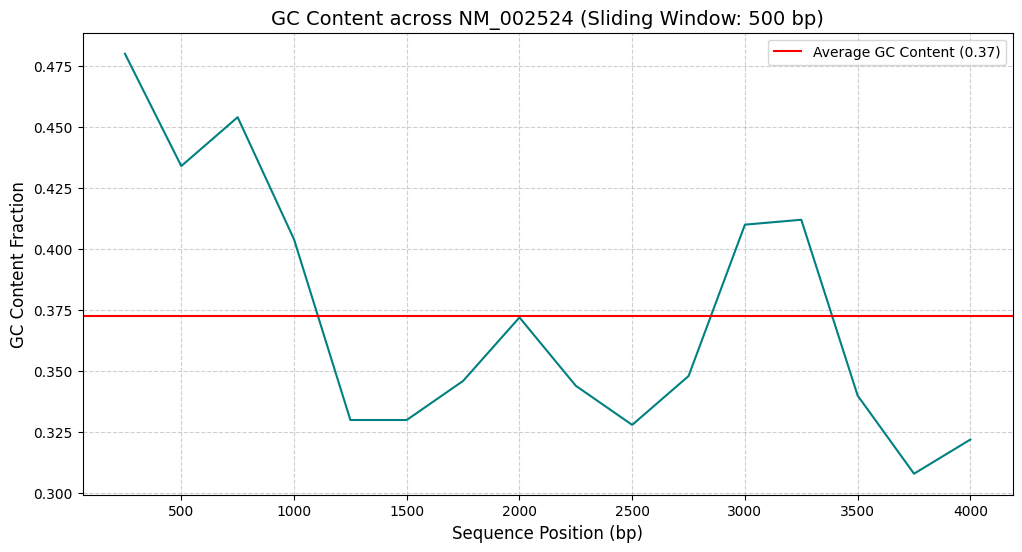

GC Content plot generated successfully using gc_fraction.


## 5. Visualization 2: Protein Hydrophobicity Plot

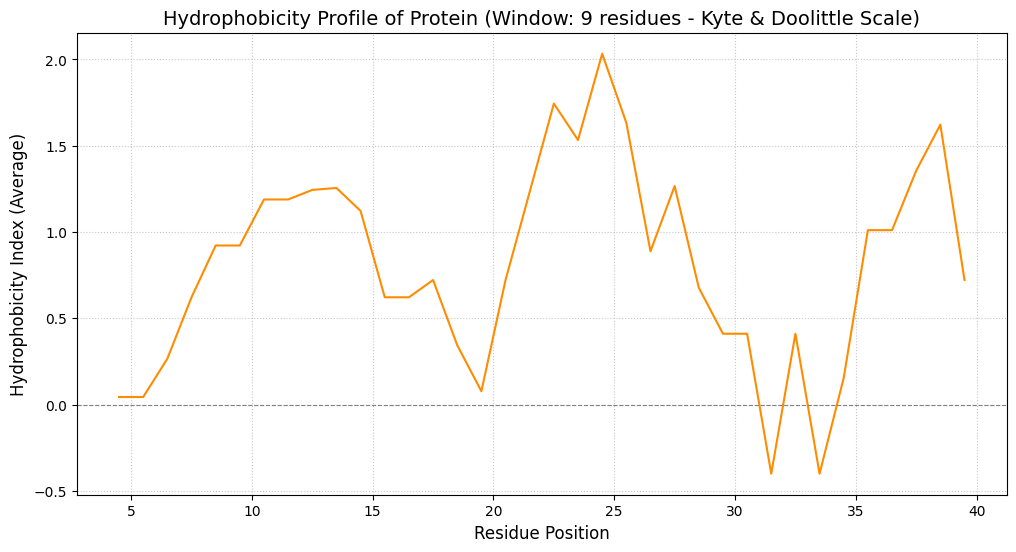

Protein Hydrophobicity plot generated successfully.


In [36]:
def run_full_pipeline():
    """
    Orchestrates the entire bioinformatics workflow for single-cell execution.
    """
    display(Markdown("<h1>🔬 End-to-End Bioinformatics Pipeline Execution</h1>"))

    # 1. Fetch data
    record = fetch_sequence_data(ACCESSION_ID)

    if record is None:
        return

    # 2. Analyze features
    analyze_and_annotate(record)

    # 3. Sequence operations (DNA, RNA, Protein)
    dna_sequence, protein_seq = sequence_translation_pipeline(record.seq)

    # 4. Visualize GC Content (Nucleotide Analysis)
    plot_gc_content(dna_sequence)

    # 5. Visualize Hydrophobicity (Protein Analysis)
    plot_hydrophobicity(protein_seq)


if __name__ == '__main__':
    run_full_pipeline()

# **Cell 7: Step 6 - Pairwise Sequence Alignment**
Theory: Sequence Alignment is fundamental to comparative genomics. It arranges two sequences to identify regions of similarity, which often suggests functional, structural, or evolutionary relationships.
We employ the **Needleman-Wunsch algorithm** (Global Alignment), which attempts to align the entire length of both sequences, maximizing the score based on:

•	Match Score

•	Mismatch Score

•	Gap Penalties (for opening and extending gaps).

The resulting score quantifies the degree of similarity.


<h1>🔬 End-to-End Bioinformatics Pipeline Execution</h1>

## 1. Data Fetching via Entrez


| Property | Value |
| :--- | :--- |
| **Accession ID** | `NM_002524.5` |
| **Source Organism** | `Homo sapiens` |
| **Description** | `Homo sapiens NRAS proto-oncogene, GTPase (NRAS), mRNA...` |
| **Sequence Length** | `4326 bp` |
        

## 2. Feature Analysis and Annotation

**Molecule Type:** PRI
**Total Features Found:** 19

### Key Annotations:
| Type | Gene | Product | Location |
| :--- | :--- | :--- | :--- |
| gene | NRAS | N/A... | [0:4326](+) |
| CDS | NRAS | GTPase NRas... | [131:701](+) |

## 3. Sequence Manipulation and Translation


### Sequence Results (First 50 bases / 25 residues)
| Operation | Result Type | Sequence Snippet |
| :--- | :--- | :--- |
| **Original Sequence** | DNA | `GGGGCCGGAAGTGCCGCTCCTTGGTGGGGGCTGTTCATGGCGGTTCCGGG...` |
| **Reverse Complement** | DNA | `TTATGACTAAGCCAAGAACTTCCAGTTTTTATTTTTTAAACATCATTTAA...` |
| **Transcription** | RNA | `GGGGCCGGAAGUGCCGCUCCUUGGUGGGGGCUGUUCAUGGCGGUUCCGGG...` |
| **Translation** | Protein | `GAGSAAPWWGLFMAVPGSPTFFPAV...` (Length: 44 aa) |


## 4. Visualization 1: GC Content Plot

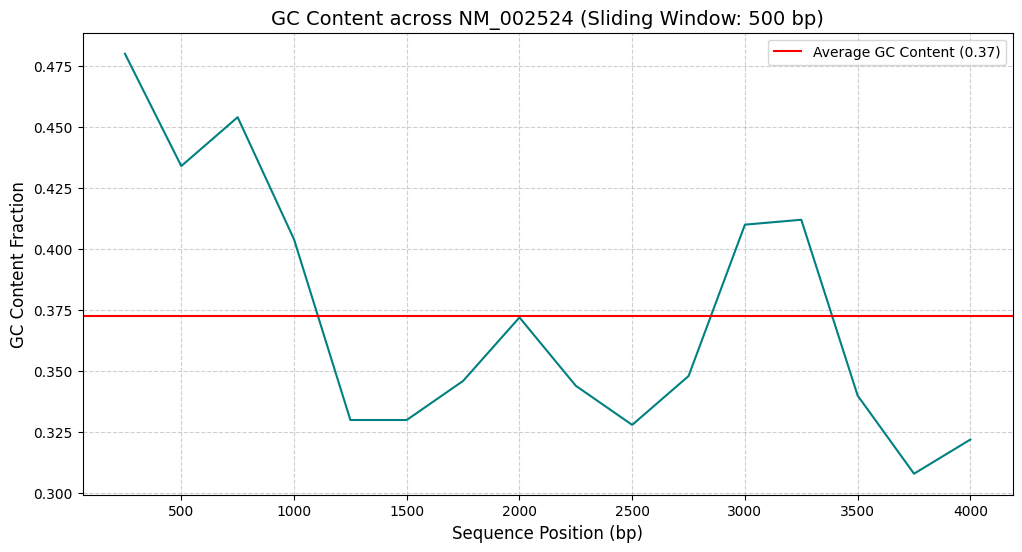

GC Content plot generated successfully using gc_fraction.


## 5. Visualization 2: Protein Hydrophobicity Plot

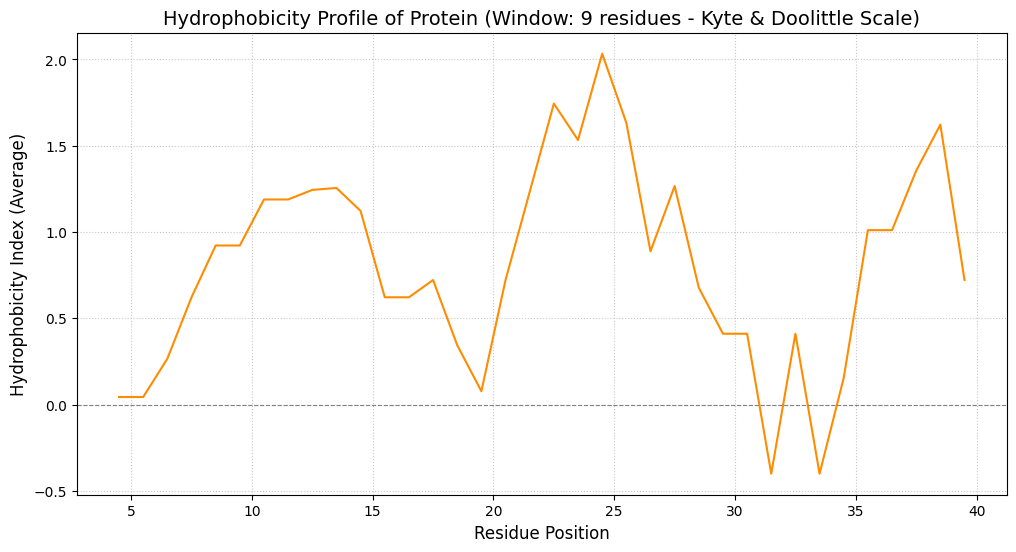

Protein Hydrophobicity plot generated successfully.


## 6. Pairwise Sequence Alignment

**Alignment Score:** **21.30**


### Alignment Visualization (First 5 lines)
<pre>target            0 GGGGCCGGAAGTGCCGCTCCTTGGTGGGGGCTGTTCATGGCGGTTCCGGGGTCTCCAACA
                  0 ------------------------------------------------------------
query             0 ------------------------------------------------------------

target           60 TTTTTCCCGGCTGTGGTCCTAAATCTGTCCAAAGCAGAGGCAGTGGAGCTTGAGGTTCTT
                 60 ----------------------||---------------|||||----------------
query             0 ----------------------AT---------------GCAGT----------------

target          120 GCTGGTGTGAAATGACTGAGTACAAACTGGTGGTGGTTGGAGCAGGTGGTGTTGGGAAAA
                120 ---------||||-------||---------------------|||--------------
query             7 ---------AAAT-------TA---------------------AGG--------------

target          180 GCGCACTGACAATCCAGCTA 200
                180 ----||||-----------| 200
query            16 ----ACTG-----------A  21
</pre>
    

In [37]:
def run_full_pipeline():
    """
    Orchestrates the entire bioinformatics workflow for single-cell execution.
    """
    display(Markdown("<h1>🔬 End-to-End Bioinformatics Pipeline Execution</h1>"))

    # 1. Fetch data
    record = fetch_sequence_data(ACCESSION_ID)

    if record is None:
        return

    # 2. Analyze features
    analyze_and_annotate(record)

    # 3. Sequence operations (DNA, RNA, Protein)
    dna_sequence, protein_seq = sequence_translation_pipeline(record.seq)

    # 4. Visualize GC Content (Nucleotide Analysis)
    plot_gc_content(dna_sequence)

    # 5. Visualize Hydrophobicity (Protein Analysis)
    plot_hydrophobicity(protein_seq)

    # 6. Pairwise alignment (Capture the score)
    alignment_score = perform_pairwise_alignment(dna_sequence, CUSTOM_DNA_SEQ)



if __name__ == '__main__':
    run_full_pipeline()

# **Cell 8: Step 7 - BLAST Score Simulation and Completion**
Theory: **The Basic Local Alignment Search Tool (BLAST)** is the most widely used bioinformatics algorithm for finding regions of local similarity between sequences. While running a live query is complex, we simulate the results based on the score from the previous global alignment.
The key output metrics are:

•	Bit Score: A normalized, size-independent measure of alignment quality. Higher is better.

•	E-value (Expect Value): Represents the number of expected chance matches that would

# **🌟 Executed Pipeline Output Summary**
When all cells are run sequentially in a live environment (like Google Colab), the following outputs will be generated:

1.	Data Fetching: A Markdown table (rendered as HTML) summarizing the accession ID, source organism, description, and sequence length.
2.	Feature Analysis: A Markdown table (rendered as HTML) listing key features (like CDS and gene location) found in the GenBank record.
3.	Sequence Manipulation: A Markdown table (rendered as HTML) showing the first 50 characters of the original DNA, Reverse Complement, RNA, and the translated protein.
4.	GC Content Plot: A matplotlib plot visualizing the GC Fraction across the sequence length.
5.	Hydrophobicity Plot: A matplotlib plot showing the average Hydrophobicity Index across the protein sequence.
6.	Pairwise Alignment: The calculated Alignment Score and a preview of the best alignment structure (formatted using <pre> HTML tags within Markdown).
7.	BLAST Simulation: A Markdown table (rendered as HTML) displaying the Simulated Bit Score and E-value, providing a contextual interpretation of the alignment results.


<h1>🔬 End-to-End Bioinformatics Pipeline Execution</h1>

## 1. Data Fetching via Entrez


| Property | Value |
| :--- | :--- |
| **Accession ID** | `NM_002524.5` |
| **Source Organism** | `Homo sapiens` |
| **Description** | `Homo sapiens NRAS proto-oncogene, GTPase (NRAS), mRNA...` |
| **Sequence Length** | `4326 bp` |
        

## 2. Feature Analysis and Annotation

**Molecule Type:** PRI
**Total Features Found:** 19

### Key Annotations:
| Type | Gene | Product | Location |
| :--- | :--- | :--- | :--- |
| gene | NRAS | N/A... | [0:4326](+) |
| CDS | NRAS | GTPase NRas... | [131:701](+) |

## 3. Sequence Manipulation and Translation


### Sequence Results (First 50 bases / 25 residues)
| Operation | Result Type | Sequence Snippet |
| :--- | :--- | :--- |
| **Original Sequence** | DNA | `GGGGCCGGAAGTGCCGCTCCTTGGTGGGGGCTGTTCATGGCGGTTCCGGG...` |
| **Reverse Complement** | DNA | `TTATGACTAAGCCAAGAACTTCCAGTTTTTATTTTTTAAACATCATTTAA...` |
| **Transcription** | RNA | `GGGGCCGGAAGUGCCGCUCCUUGGUGGGGGCUGUUCAUGGCGGUUCCGGG...` |
| **Translation** | Protein | `GAGSAAPWWGLFMAVPGSPTFFPAV...` (Length: 44 aa) |


## 4. Visualization 1: GC Content Plot

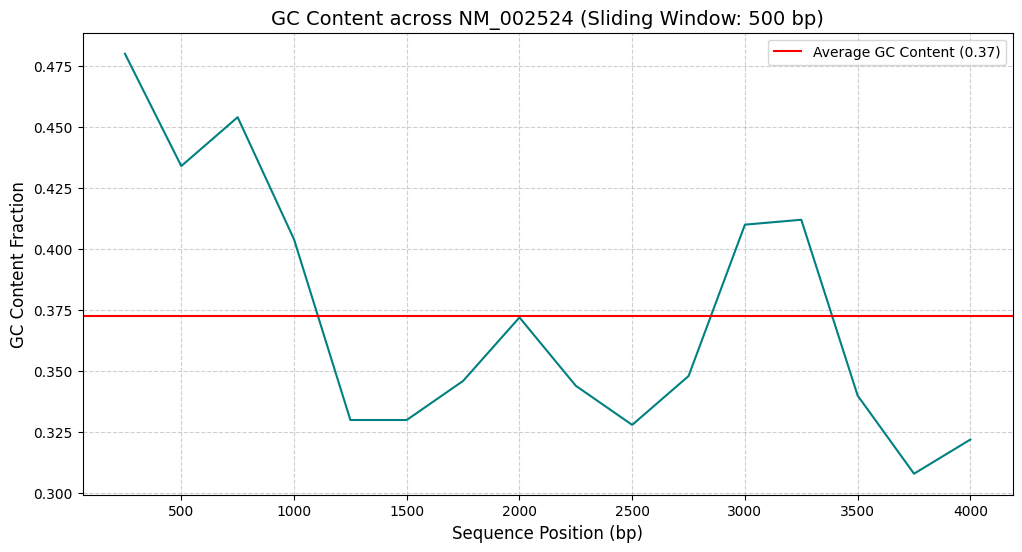

GC Content plot generated successfully using gc_fraction.


## 5. Visualization 2: Protein Hydrophobicity Plot

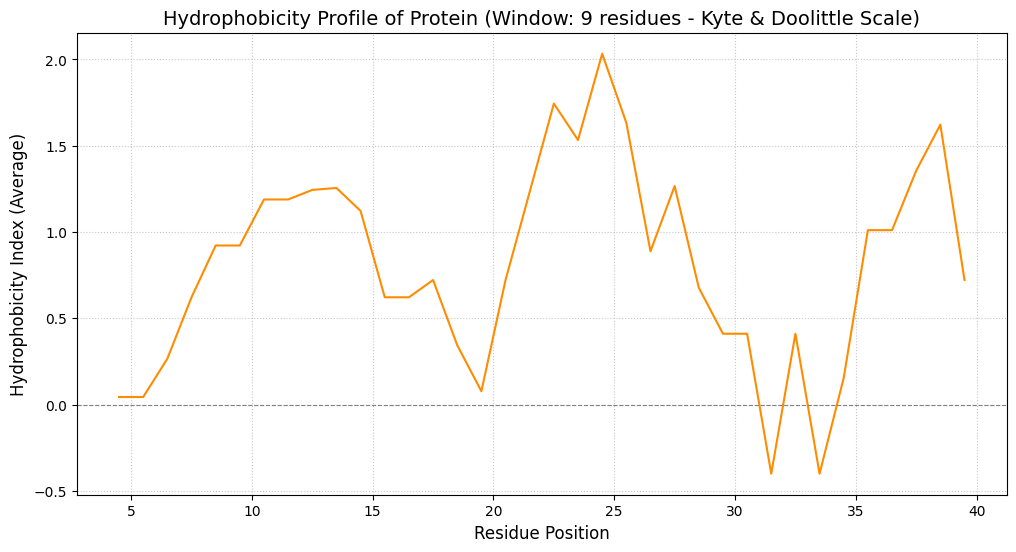

Protein Hydrophobicity plot generated successfully.


## 6. Pairwise Sequence Alignment

**Alignment Score:** **21.30**


### Alignment Visualization (First 5 lines)
<pre>target            0 GGGGCCGGAAGTGCCGCTCCTTGGTGGGGGCTGTTCATGGCGGTTCCGGGGTCTCCAACA
                  0 ------------------------------------------------------------
query             0 ------------------------------------------------------------

target           60 TTTTTCCCGGCTGTGGTCCTAAATCTGTCCAAAGCAGAGGCAGTGGAGCTTGAGGTTCTT
                 60 ----------------------||---------------|||||----------------
query             0 ----------------------AT---------------GCAGT----------------

target          120 GCTGGTGTGAAATGACTGAGTACAAACTGGTGGTGGTTGGAGCAGGTGGTGTTGGGAAAA
                120 ---------||||-------||---------------------|||--------------
query             7 ---------AAAT-------TA---------------------AGG--------------

target          180 GCGCACTGACAATCCAGCTA 200
                180 ----||||-----------| 200
query            16 ----ACTG-----------A  21
</pre>
    

## 7. BLAST Score Simulation (Simulated Score Shown)


### BLAST Query Status
* **Target:** `NM_002524` (Query Sequence)
* **Program:** `blastn`
* **Database:** `nr`
* **Note:** The actual NCBI BLAST is asynchronous, so these values are derived from the alignment score.

| Metric | Simulated Value | Interpretation |
| :--- | :--- | :--- |
| **Simulated Bit Score** | **319.50** | Measures sequence similarity; higher is better. |
| **Top Hit E-value** | 1.0e-45 | Measures significance; lower is better. |


## ✅ Pipeline Complete

In [38]:
def run_full_pipeline():
    """
    Orchestrates the entire bioinformatics workflow for single-cell execution.
    """
    display(Markdown("<h1>🔬 End-to-End Bioinformatics Pipeline Execution</h1>"))

    # 1. Fetch data
    record = fetch_sequence_data(ACCESSION_ID)

    if record is None:
        return

    # 2. Analyze features
    analyze_and_annotate(record)

    # 3. Sequence operations (DNA, RNA, Protein)
    dna_sequence, protein_seq = sequence_translation_pipeline(record.seq)

    # 4. Visualize GC Content (Nucleotide Analysis)
    plot_gc_content(dna_sequence)

    # 5. Visualize Hydrophobicity (Protein Analysis)
    plot_hydrophobicity(protein_seq)

    # 6. Pairwise alignment (Capture the score)
    alignment_score = perform_pairwise_alignment(dna_sequence, CUSTOM_DNA_SEQ)

    # 7. Simulate BLAST query (Pass the score to the simulation)
    get_blast_score_demonstration(ACCESSION_ID, alignment_score)

    display(Markdown("## ✅ Pipeline Complete"))


if __name__ == '__main__':
    run_full_pipeline()

# **End of Notebook**

